In [128]:
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from pytorch3d.io import load_objs_as_meshes, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRasterizer,
    MeshRenderer,
    SoftPhongShader,
    SoftSilhouetteShader,
    TexturesVertex
)
from pytorch3d.renderer.blending import (
    BlendParams,
    sigmoid_alpha_blend
)

from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.transforms import euler_angles_to_matrix
from pytorch3d.transforms.transform3d import Transform3d, Rotate, Translate
from pytorch3d.structures import join_meshes_as_batch, join_meshes_as_scene

In [129]:
# setup cuda/cpu device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device=device)
    # clear cache
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

# setup data
DATA_DIR = "../data/model/packet/"
obj_file = os.path.join(DATA_DIR, "mesh.obj")

# load mesh obj
mesh = load_objs_as_meshes([obj_file], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)))

In [ ]:
elev = [0]
azim = [180]
# num_views = 1
# elev = torch.linspace(0, 360, num_views)
# azim = torch.linspace(-180, 180, num_views)
R, T = look_at_view_transform(dist=3, elev=elev, azim=azim)
camera = OpenGLPerspectiveCameras(
    R = R,
    T = T,
    device = device
)
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

image_size = 128

scene = plot_scene({
    "figure": {
        "Mesh": mesh,
        "Camera": camera
    }
})
scene.show()

In [ ]:
c1 = torch.rand(1,3) # random center1
c2 = torch.rand(1,3) # random center2

r_angle1 = torch.deg2rad(torch.randint(0,360, (1,3))) # random rotation along x,y,z for mesh1
r_angle2 = torch.deg2rad(torch.randint(0,360, (1,3))) # random rotation along x,y,z for mesh2

R1 = euler_angles_to_matrix(r_angle1, "XYZ")
R2 = euler_angles_to_matrix(r_angle2, "XYZ")

rotate1 = Rotate(R1, device=device)
rotate2 = Rotate(R2, device=device)
translate1 = Translate(c1, device=device)
translate2 = Translate(c2, device=device)

transform1 = Transform3d(device=device).compose(rotate1).compose(translate1)
transform2 = Transform3d(device=device).compose(rotate2).compose(translate2)

mesh1 = mesh.clone()
mesh2 = mesh.clone()
mesh1 = mesh1.update_padded(transform1.transform_points(mesh1.verts_padded()))
mesh2 = mesh2.update_padded(transform2.transform_points(mesh2.verts_padded()))

meshes = join_meshes_as_batch([mesh1, mesh2], include_textures=True)

scene1 = plot_scene({
    "figure": {
        "Mesh": meshes,
        "Camera": camera
    }
})
scene1.show()

meshes2 = join_meshes_as_scene([mesh1, mesh2], include_textures=True)

scene2 = plot_scene({
    "figure": {
        "Mesh": meshes2,
        "Camera": camera
    }
})
scene2.show()

In [ ]:
raster_settings = RasterizationSettings(
    image_size=image_size, blur_radius=0.0, faces_per_pixel=1,
)
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(raster_settings=raster_settings),
    shader = SoftPhongShader(device=device, lights=lights, cameras=camera)
)

rendered_images = renderer(meshes, cameras=camera)
image = rendered_images[0].cpu().numpy()
print(image[...,3].max())
plt.figure()
plt.imshow(image[...,:3])


image = rendered_images[1].cpu().numpy()
print(image[...,3].max())
plt.figure()
plt.imshow(image[...,:3])

rendered_images2 = renderer(meshes2, cameras=camera)
image = rendered_images2[0].cpu().numpy()
print(image[...,3].max())
plt.figure()
plt.imshow(image[...,:3])


In [ ]:
class SimpleShader(torch.nn.Module):
    def __init__(self, device="cpu"):
        super().__init__()
    def forward(self, fragments, meshes, **kwargs) -> torch.Tensor:
        N, H, W, K = fragments.pix_to_face.shape
        device = fragments.pix_to_face.device

        # background mask
        is_background = fragments.pix_to_face[..., 0] < 0
        is_background = is_background.unsqueeze(3)
        bg = torch.zeros((N,H,W,1)).to(device)
        #fg = torch.ones((N,H,W,1)).to(device)
        fg = torch.stack([torch.ones(H,W,1) * i for i in range(1,N+1)]).to(device)
        images = bg + (~is_background * fg)
        # colors = torch.ones_like(fragments.bary_coords)
        #blend_params = kwargs.get("blend_params", BlendParams())
        #images = sigmoid_alpha_blend(colors, fragments, blend_params)
        return images # (N, H, W, 1) RGBA image

sigma = 1e-4
raster_settings = RasterizationSettings(
    image_size=image_size,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(raster_settings=raster_settings),
    shader = SimpleShader()
)

rendered_images = renderer(meshes, cameras=camera)
image = rendered_images[0].cpu().numpy()
print(image.shape)
print(image[...,0].max())
plt.figure()
plt.imshow(image[...,0])
print(image.shape)

image = rendered_images[1].cpu().numpy()
print(image.shape)
print(image[...,0].max())
plt.figure()
plt.imshow(image[...,0])
print(image.shape)

print(rendered_images.shape)

for i, img in enumerate(rendered_images.cpu().numpy()):
    (x,y) = np.where(img[:,:,0] > 0)
    m = img[x,y].mean()
    print(i, m, x.shape, y.shape, np.sqrt(x.shape))

rendered_images2 = renderer(meshes2, cameras=camera)
image = rendered_images2[0].cpu().numpy()
print(image.shape)
print(image[...,0].max())
plt.figure()
plt.imshow(image[...,0])
print(image.shape)

In [ ]:
class MeshRendererWithDepth(torch.nn.Module):
    def __init__(self, rasterizer, shader):
        super().__init__()
        self.rasterizer = rasterizer
        self.shader = shader

    def forward(self, meshes_world, **kwargs) -> torch.Tensor:
        fragments = self.rasterizer(meshes_world, **kwargs)
        images = self.shader(fragments, meshes_world, **kwargs)
        return images, fragments.zbuf

renderer = MeshRendererWithDepth(
    rasterizer=MeshRasterizer(raster_settings=raster_settings),
    shader = SimpleShader()
)

rendered_images, depth = renderer(meshes2, cameras=camera)
image = rendered_images[0].cpu().numpy()
print(image.shape)
print(image[...,0].max())
plt.imshow(image[...,0])
print(image.shape)

d = depth.cpu().numpy()
print(d.shape)
print(d[0,:,:,0].shape)
print(d.min(), d.max())
plt.figure()
plt.imshow(d[0,:,:,0], cmap='gray')
plt.colorbar(label="Depth in m")
plt.show()

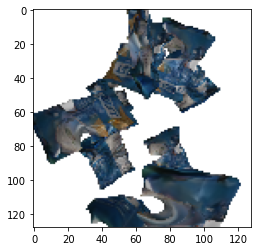

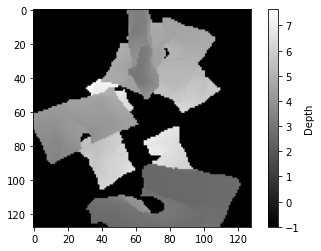

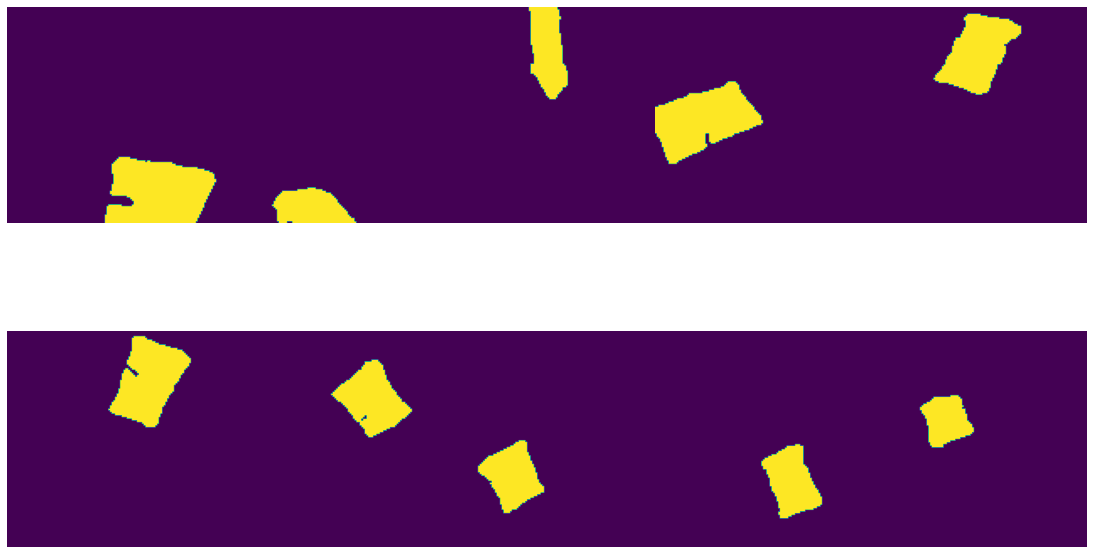

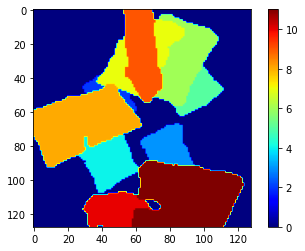

In [194]:
num_objects = 10
# centers = torch.rand(num_objects, 3) * 2 # random centers for each object. Multiply by a scalar to space object farther
# x = torch.linspace(-2,2,10)
# y = torch.linspace(-2,2,10)
z = torch.linspace(-2,2,10)
y = torch.rand(num_objects) * 4
x = torch.rand(num_objects) * 4
#z = torch.rand(num_objects)
centers = torch.stack([x,y,z], dim=1)
angles = torch.deg2rad(torch.randint(0, 360, (num_objects, 3))) # random rotation angles for each object.
R = euler_angles_to_matrix(angles, "XYZ") # rotation matrix from axis/euler angles.
rotate = Rotate(R, device=device) # rotation transformation
translate = Translate(centers, device=device) # tranlation transformation
transform = Transform3d(device=device).compose(rotate).compose(translate) # combined transformation for each object

meshes = mesh.extend(num_objects) # create num_object meshes
meshes = meshes.update_padded(transform.transform_points(meshes.verts_padded())) # transform each object mesh

# setup camera
R = torch.eye(3).unsqueeze(0)
T = torch.tensor([[-x.mean(), -y.mean(), 5]])
cameras = OpenGLPerspectiveCameras(
    R = R,
    T = T,
    #fov = 60,
    device = device
)
cameras.get_camera_center()
transform = cameras.get_world_to_view_transform()
transform.get_matrix()
lights = PointLights(device=device, location=[[0.0, 0.0, -5.0]])
image_size = 128

scene = plot_scene({
    "figure": {
        "Mesh": meshes,
        "Camera": cameras
    }
})
scene.show()

class MeshRendererWithDepth(torch.nn.Module):
    def __init__(self, rasterizer, shader):
        super().__init__()
        self.rasterizer = rasterizer
        self.shader = shader

    def forward(self, meshes_world, **kwargs) -> torch.Tensor:
        fragments = self.rasterizer(meshes_world, **kwargs)
        images = self.shader(fragments, meshes_world, **kwargs)
        return images, fragments.zbuf

class MaskShader(torch.nn.Module):
    def __init__(self, device="cpu"):
        super().__init__()
    def forward(self, fragments, meshes, **kwargs) -> torch.Tensor:
        N, H, W, K = fragments.pix_to_face.shape
        device = fragments.pix_to_face.device

        # background mask
        is_background = fragments.pix_to_face[..., 0] < 0
        is_background = is_background.unsqueeze(3)
        bg = torch.zeros((N,H,W,1)).to(device)
        #fg = torch.ones((N,H,W,1)).to(device)
        fg = torch.stack([torch.ones(H,W,1) * i for i in range(N+1,1,-1)]).to(device)
        images = bg + (~is_background * fg)
        return images # (N, H, W, 1) RGBA image

raster_settings = RasterizationSettings(
    image_size=image_size, blur_radius=0.0, faces_per_pixel=1,
    perspective_correct=True,
    clip_barycentric_coords=True
)
renderer = MeshRendererWithDepth(
    rasterizer=MeshRasterizer(raster_settings=raster_settings),
    shader = SoftPhongShader(device=device, lights=lights, cameras=cameras)
)

rendered_images, depth = renderer(join_meshes_as_scene(meshes), cameras=cameras)
image = rendered_images[0].cpu().numpy()
depth_img = depth.cpu().numpy()
plt.figure()
plt.imshow(image[...,:3])
plt.figure()
plt.imshow(depth_img[0,:,:,0], cmap='gray')
plt.colorbar(label="Depth")
plt.show()



def custom_image_grid(
    images,
    rows=None,
    cols=None,
    fill: bool = True,
    show_axes: bool = False,
    rgb: bool = True,
):
    """
    A util function for plotting a grid of images.

    Args:
        images: (N, H, W, 4) array of RGBA images
        rows: number of rows in the grid
        cols: number of columns in the grid
        fill: boolean indicating if the space between images should be filled
        show_axes: boolean indicating if the axes of the plots should be visible
        rgb: boolean, If True, only RGB channels are plotted.
            If False, only the alpha channel is plotted.

    Returns:
        None
    """
    if (rows is None) != (cols is None):
        raise ValueError("Specify either both rows and cols or neither.")

    if rows is None:
        rows = len(images)
        cols = 1

    gridspec_kw = {"wspace": 0.0, "hspace": 0.0} if fill else {}
    fig, axarr = plt.subplots(rows, cols, gridspec_kw=gridspec_kw, figsize=(15, 9))
    bleed = 0
    fig.subplots_adjust(left=bleed, bottom=bleed, right=(1 - bleed), top=(1 - bleed))

    for ax, im in zip(axarr.ravel(), images):
        if rgb:
            # only render RGB channels
            ax.imshow(im[..., :3])
        else:
            # only render Alpha channel
            ax.imshow(im[..., 0])
        if not show_axes:
            ax.set_axis_off()

sigma = 1e-4
mask_raster_settings = RasterizationSettings(
    image_size=image_size,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

mask_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(raster_settings=mask_raster_settings),
    shader = MaskShader()
)

mask_images = mask_renderer(meshes, cameras=cameras)
custom_image_grid(mask_images.cpu().numpy(), rows=2, cols=5, rgb=False)
plt.show()

masks = mask_images.cpu().numpy()
single_mask = masks.max(axis=0)
single_mask.shape
plt.imshow(single_mask, cmap='jet')
plt.colorbar()
plt.show()

torch.Size([16384, 3])


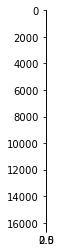

In [186]:
sparse_depth = depth.to_sparse()
indices = sparse_depth.indices()
values = sparse_depth.values()
xy_depth = torch.cat((indices.T, values[...,None]), dim=-1)
xyz_unproj_world = cameras.unproject_points(xy_depth[:,:3], world_coordinates=True)
print(xyz_unproj_world.shape)
plt.imshow(xyz_unproj_world.cpu().numpy())

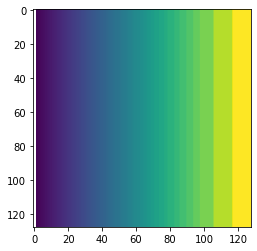

In [187]:
d = xyz_unproj_world.reshape(128,128,3).cpu().numpy()
d.shape
plt.imshow(d[:,:,2])